# KENDAXA ASSIGNMENT - MACHINE LEARNING POSITION
## Amphibians Classification - *by Jan Kořínek*

### Deliverable goals
#### Classification task

Your goal is to perform exploratory data analysis (EDA)
and to train and compare few models on a classification
task using the dataset Amphibians (https://archive.ics.uci.edu/ml/datasets/Amphibians). Your task is to evaluate the
prediction of the presence of individual amphibians, namely *green frogs, brown frogs, common toad, fire-bellied toad, tree frog,
common newt, and great crested new*. You are not to use the ID
and MV features.

Since your goal is to evaluate and compare several
models along with finding the best one, you have to use
some kind of cross-validation as the dataset is quite small
(which is very common for some of the real world datasets).

If you find it applicable, use statistical tests in the EDA and comparison to distinguish between insignificant differ-
ences and significant ones.

#### Report and scope

You are required to write a brief report in the PDF format
(L A TEXusage is recommend) summarizing the approaches
and presenting the results for all three subtasks. It is rec-
ommend to use figures and plots where it will help you
make your point. The report should contain all the necessary
details to understand what approach you have undertaken,
what were the results and how you interpret them.

our report should summarize the main results of your EDA
but it is sufficient to have the details of the EDA only in the
Jupyter notebook. Briefly (very briefly) introduce the used
models. You should compare the models with regards to
more than one metric each with explanation when is each of
the metrics preferable. You should also state your trust in the
individual models — e.g., that even if some model gives you
very good results, you still might not trust it because it is
sensitive to the data changes. Compare the models also with
respect to their robustness and interpretability. Interpret the
few models you will select as your top ranking candidates,
show which features they are relying the most, etc. Where
applicable, perform formal statistical tests to support your
results.

Please, also state the limitations of your work and direc-
tions, in which it can be expanded — it is expected that you
will not be able to exhaust all possible approaches in the
limited time. Please state which of the possible expansions
are most promising and why.

The report is expected to have about 5–12 pages when using
two-column format with figures but there are no hard limits
as the completeness of the presented information is the
goal (as long as there are no empty sentences or fillers, the
length will not be evaluated).

### Content
[1. Amphibians dataset preparation](#dataset-preparation)

[2. Initial dataset exploration](#dataset-exploration)

[3. Feature engineering](#feature-eng)

[4. Training of the multiple models](models-training)

[5. Results Discussion and Conclusion](conclusion)

### 1. Amphibians dataset preparation <a name="dataset-preparation"></a>

In [1]:
# Load and extract data from raw CSVs into dataframes
%run lib/prepare_dataset.py

# Show processed df
amphibians

Processing raw data...
Dataset processing finished in: 0:00:00


,SR,NR,TR,VR,SUR1,SUR2,SUR3,UR,FR,OR,...,BR,MR,CR,Green frogs,Brown frogs,Common toad,Fire-bellied toad,Tree frog,Common newt,Great crested newt
0,600,1,1,4,6,2,10,0,0,50,...,0,0,1,0,0,0,0,0,0,0
1,700,1,5,1,10,6,10,3,1,75,...,1,0,1,0,1,1,0,0,1,0
2,200,1,5,1,10,6,10,3,4,75,...,1,0,1,0,1,1,0,0,1,0
3,300,1,5,0,6,10,2,3,4,25,...,0,0,1,0,0,1,0,0,0,0
4,600,2,1,4,10,2,6,0,0,99,...,5,0,1,0,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,2300,1,12,3,2,2,1,0,0,75,...,1,0,1,0,1,0,0,0,0,0
185,300,1,14,2,7,10,2,0,0,100,...,5,0,1,1,1,1,1,0,1,0
186,500,1,1,4,1,10,2,0,0,100,...,5,0,1,1,1,1,1,0,1,0
187,300,1,12,3,2,1,6,0,0,100,...,0,0,1,0,1,1,0,0,0,0


### 2. Initial dataset exploration <a name="dataset-exploration"></a>

#### Libraries Import and Fonts setup

In [2]:
import copy
import datetime, warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lib.misc_functions import print_corr_matrix, remove_outliers, encode_labels,\
    run_ml_sampling, concat_df

# Warnings turn off
warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings('ignore')
warnings.warn('ignore')

pd.set_option("display.max.columns", None)
plt.style.use('seaborn')
%matplotlib inline

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rcParams['figure.facecolor'] = 'white'
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

In [3]:
#check the df head
amphibians.head(5)

,SR,NR,TR,VR,SUR1,SUR2,SUR3,UR,FR,OR,RR,BR,MR,CR,Green frogs,Brown frogs,Common toad,Fire-bellied toad,Tree frog,Common newt,Great crested newt
0,600,1,1,4,6,2,10,0,0,50,0,0,0,1,0,0,0,0,0,0,0
1,700,1,5,1,10,6,10,3,1,75,1,1,0,1,0,1,1,0,0,1,0
2,200,1,5,1,10,6,10,3,4,75,1,1,0,1,0,1,1,0,0,1,0
3,300,1,5,0,6,10,2,3,4,25,0,0,0,1,0,0,1,0,0,0,0
4,600,2,1,4,10,2,6,0,0,99,0,5,0,1,0,1,1,1,0,1,1


In [4]:
#check the df tail
amphibians.tail(5)

,SR,NR,TR,VR,SUR1,SUR2,SUR3,UR,FR,OR,RR,BR,MR,CR,Green frogs,Brown frogs,Common toad,Fire-bellied toad,Tree frog,Common newt,Great crested newt
184,2300,1,12,3,2,2,1,0,0,75,2,1,0,1,0,1,0,0,0,0,0
185,300,1,14,2,7,10,2,0,0,100,5,5,0,1,1,1,1,1,0,1,0
186,500,1,1,4,1,10,2,0,0,100,5,5,0,1,1,1,1,1,0,1,0
187,300,1,12,3,2,1,6,0,0,100,1,0,0,1,0,1,1,0,0,0,0
188,300,1,12,3,2,6,10,0,0,100,1,1,0,1,0,1,1,0,0,0,0


In [5]:
# check sampled data
amphibians.sample(10)

,SR,NR,TR,VR,SUR1,SUR2,SUR3,UR,FR,OR,RR,BR,MR,CR,Green frogs,Brown frogs,Common toad,Fire-bellied toad,Tree frog,Common newt,Great crested newt
20,7000,6,1,1,6,10,2,3,4,50,0,0,0,1,1,0,1,0,0,0,0
170,1000,2,1,3,2,6,1,0,0,100,0,1,0,1,1,1,1,1,1,1,1
13,1700,1,1,1,2,6,10,0,1,100,2,2,2,1,1,1,1,0,0,0,0
109,8300,2,1,2,1,10,6,3,3,100,2,2,0,1,1,1,1,0,1,0,0
73,9100,1,1,0,7,10,2,3,3,100,5,5,0,1,1,0,0,0,0,0,0
98,8250,1,1,3,6,2,10,0,0,100,1,2,0,1,1,1,1,1,1,1,1
113,900,1,1,1,1,10,6,3,2,100,2,2,0,1,1,1,1,1,1,1,0
14,8000,1,1,3,2,10,7,0,0,100,9,9,0,1,0,1,1,0,0,0,0
8,750,2,5,1,6,1,2,0,1,50,1,0,0,1,0,1,1,0,0,0,0
85,9000,3,1,2,10,10,10,0,1,100,9,9,0,1,1,1,1,0,1,0,0


In [6]:
# check the data types
amphibians.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   SR                  189 non-null    int64
 1   NR                  189 non-null    int64
 2   TR                  189 non-null    int64
 3   VR                  189 non-null    int64
 4   SUR1                189 non-null    int64
 5   SUR2                189 non-null    int64
 6   SUR3                189 non-null    int64
 7   UR                  189 non-null    int64
 8   FR                  189 non-null    int64
 9   OR                  189 non-null    int64
 10  RR                  189 non-null    int64
 11  BR                  189 non-null    int64
 12  MR                  189 non-null    int64
 13  CR                  189 non-null    int64
 14  Green frogs         189 non-null    int64
 15  Brown frogs         189 non-null    int64
 16  Common toad         189 non-null    int64
 1

In [7]:
# descriptive statistics summary
amphibians.describe()

,SR,NR,TR,VR,SUR1,SUR2,SUR3,UR,FR,OR,RR,BR,MR,CR,Green frogs,Brown frogs,Common toad,Fire-bellied toad,Tree frog,Common newt,Great crested newt
count,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.00000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000
mean,9633.227513,1.566138,4.952381,1.904762,4.232804,5.391534,5.84127,0.841270,0.846561,89.962963,2.333333,2.502646,0.047619,1.015873,0.571429,0.783069,0.656085,0.306878,0.375661,0.306878,0.111111
std,46256.078309,1.544419,5.590918,1.317407,3.434615,3.515185,3.29348,1.315291,1.349843,19.904926,2.520132,2.640971,0.296894,0.125316,0.496186,0.413250,0.476275,0.462423,0.485580,0.462423,0.315104
min,30.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.00000,0.000000,0.000000,25.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,300.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.00000,0.000000,0.000000,99.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,700.000000,1.000000,1.000000,2.000000,2.000000,6.000000,6.00000,0.000000,0.000000,100.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,3300.000000,1.000000,12.000000,3.000000,7.000000,9.000000,9.00000,3.000000,2.000000,100.000000,5.000000,5.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,500000.000000,12.000000,15.000000,4.000000,14.000000,11.000000,11.00000,3.000000,4.000000,100.000000,10.000000,10.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Missing Values Check

In [8]:
# Missing nan values check
amphibians.isna().sum().sort_values(ascending=False)


SR                    0
BR                    0
Common newt           0
Tree frog             0
Fire-bellied toad     0
Common toad           0
Brown frogs           0
Green frogs           0
CR                    0
MR                    0
RR                    0
NR                    0
OR                    0
FR                    0
UR                    0
SUR3                  0
SUR2                  0
SUR1                  0
VR                    0
TR                    0
Great crested newt    0
dtype: int64

In [9]:
# Missing zero values check
amphibians.isnull().sum().sort_values(ascending=False)

SR                    0
BR                    0
Common newt           0
Tree frog             0
Fire-bellied toad     0
Common toad           0
Brown frogs           0
Green frogs           0
CR                    0
MR                    0
RR                    0
NR                    0
OR                    0
FR                    0
UR                    0
SUR3                  0
SUR2                  0
SUR1                  0
VR                    0
TR                    0
Great crested newt    0
dtype: int64

In [10]:
# Check values counts
amphibians.value_counts()


SR      NR  TR  VR  SUR1  SUR2  SUR3  UR  FR  OR   RR  BR  MR  CR  Green frogs  Brown frogs  Common toad  Fire-bellied toad  Tree frog  Common newt  Great crested newt
300     1   15  1   10    1     6     0   0   100  1   1   0   1   0            1            1            0                  0          0            0                     2
30      1   1   2   2     7     6     0   0   75   0   1   0   1   0            1            1            0                  0          1            0                     1
2300    1   12  3   2     2     1     0   0   75   2   1   0   1   0            1            0            0                  0          0            0                     1
1800    1   1   0   10    1     6     3   2   100  1   2   0   1   1            1            1            1                  1          1            1                     1
1900    7   12  4   2     6     7     0   0   100  5   5   0   1   1            1            0            0                  1          1   

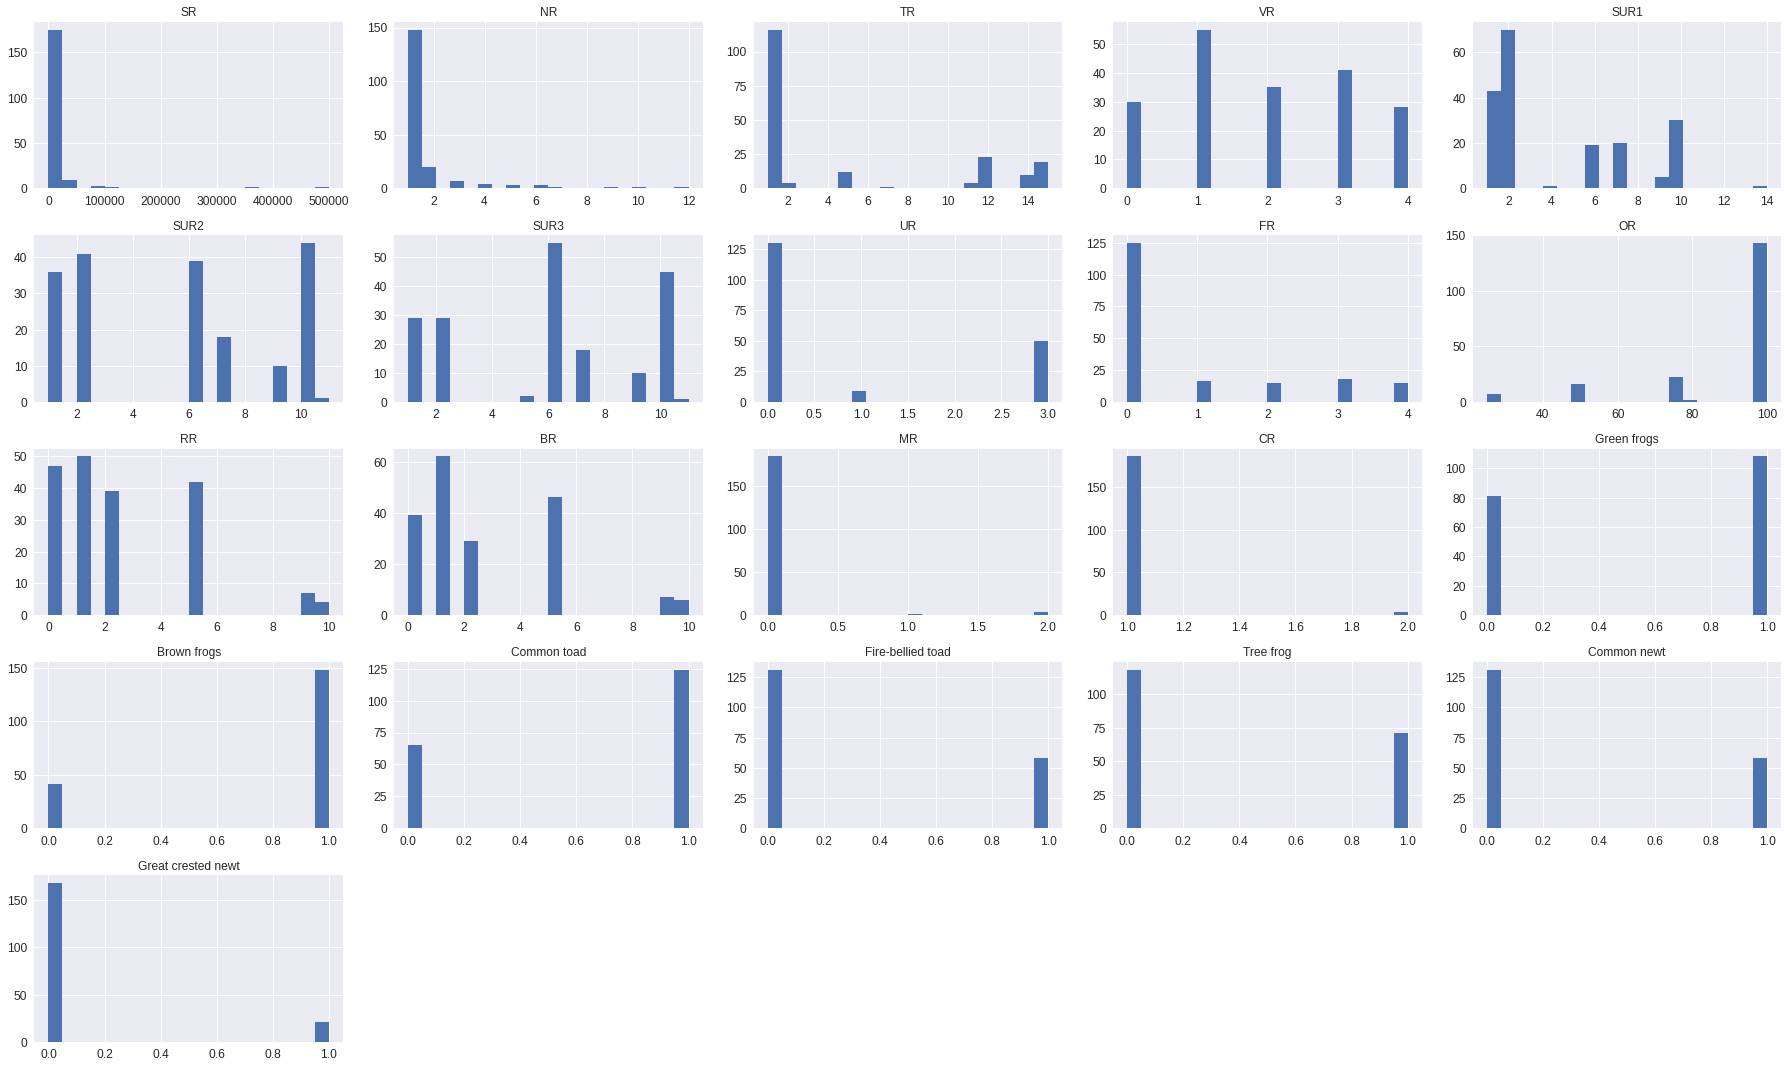

In [11]:
# Print data histogram
amphibians.hist(figsize=(25,15), bins=20)
plt.tight_layout()
plt.savefig('export/amphibians_histogram.pdf', dpi=600)

#### Correlation Matrix Visualization

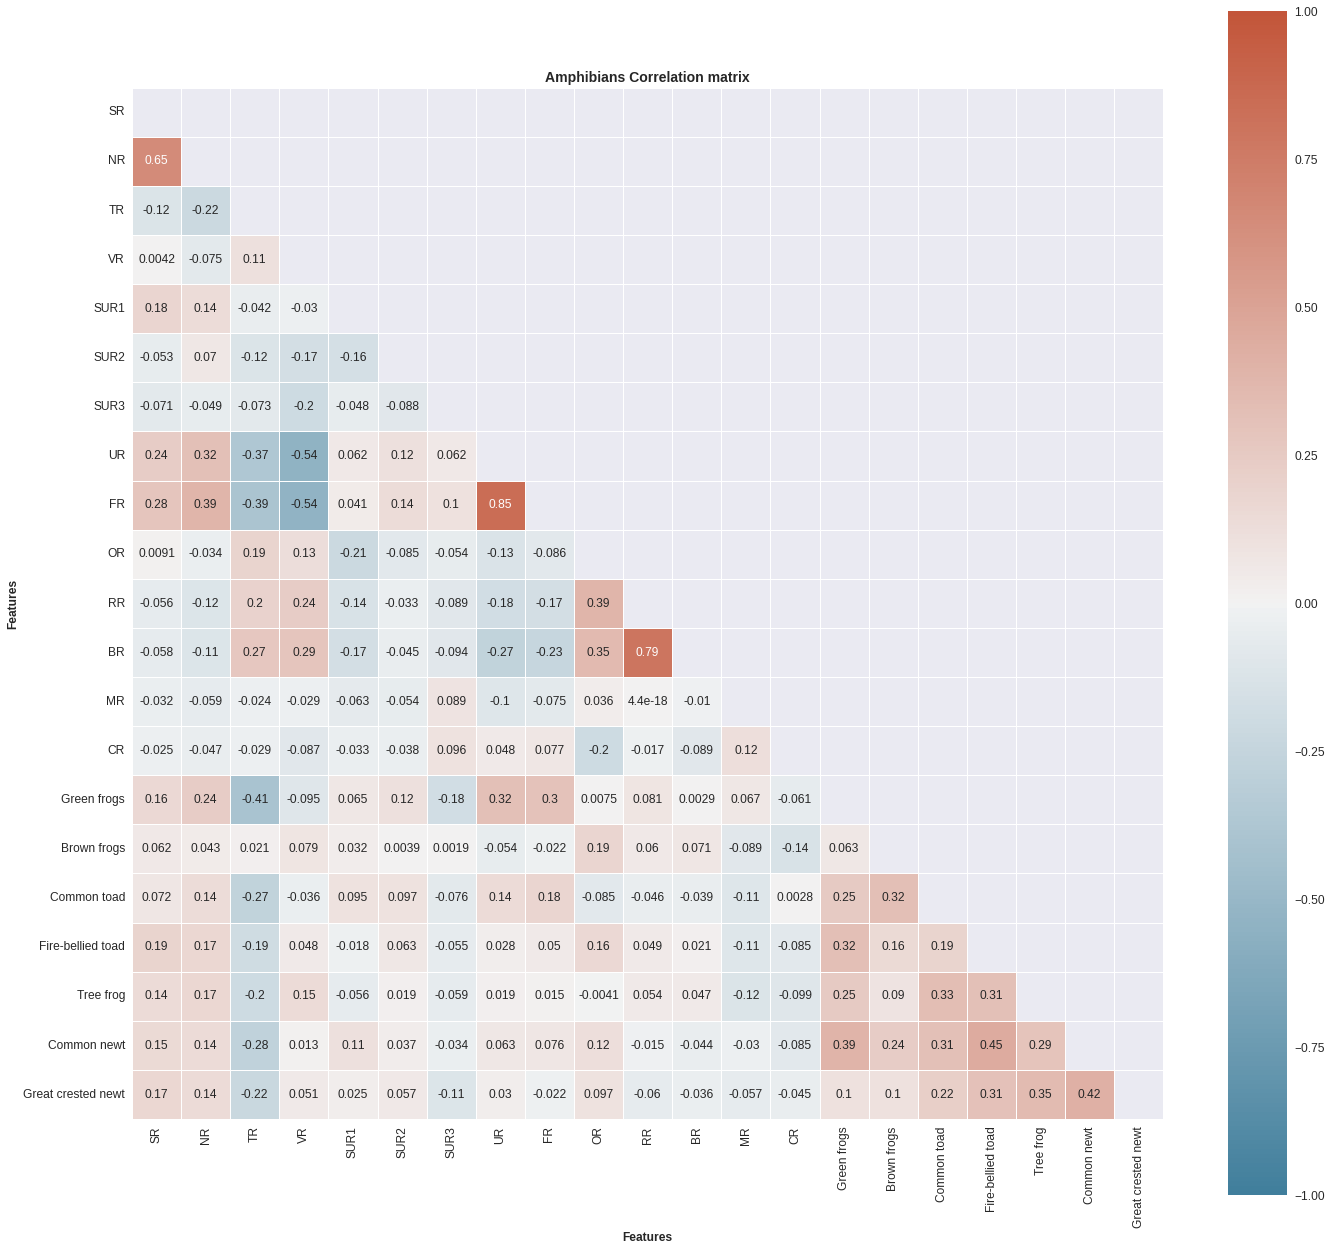

In [12]:
# Print correlation matrix
corr = print_corr_matrix(amphibians)

#### Pairs sorting

In [13]:
# Pair sorting
corr_pairs = corr.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort")
sorted_pairs.drop_duplicates(inplace=True)

print('----- Strong Positive Pairs -----')
strong_positive_pairs = sorted_pairs[sorted_pairs > 0.5]
strong_positive_pairs.drop_duplicates(inplace=True)
print(strong_positive_pairs,'\n')

print('----- Strong Negative Pairs -----')
strong_negative_pairs = sorted_pairs[sorted_pairs < -0.5]
strong_negative_pairs.drop_duplicates(inplace=True)
print(strong_negative_pairs,'\n \n')

----- Strong Positive Pairs -----
SR  NR    0.652757
RR  BR    0.792273
UR  FR    0.846052
SR  SR    1.000000
dtype: float64 

----- Strong Negative Pairs -----
UR  VR   -0.542904
FR  VR   -0.537696
dtype: float64 
 



### Outliers handling

In [14]:
SR_lim = 11000
NR_lim = 4
amphibians_rem_out = remove_outliers(amphibians, SR_lim, NR_lim)

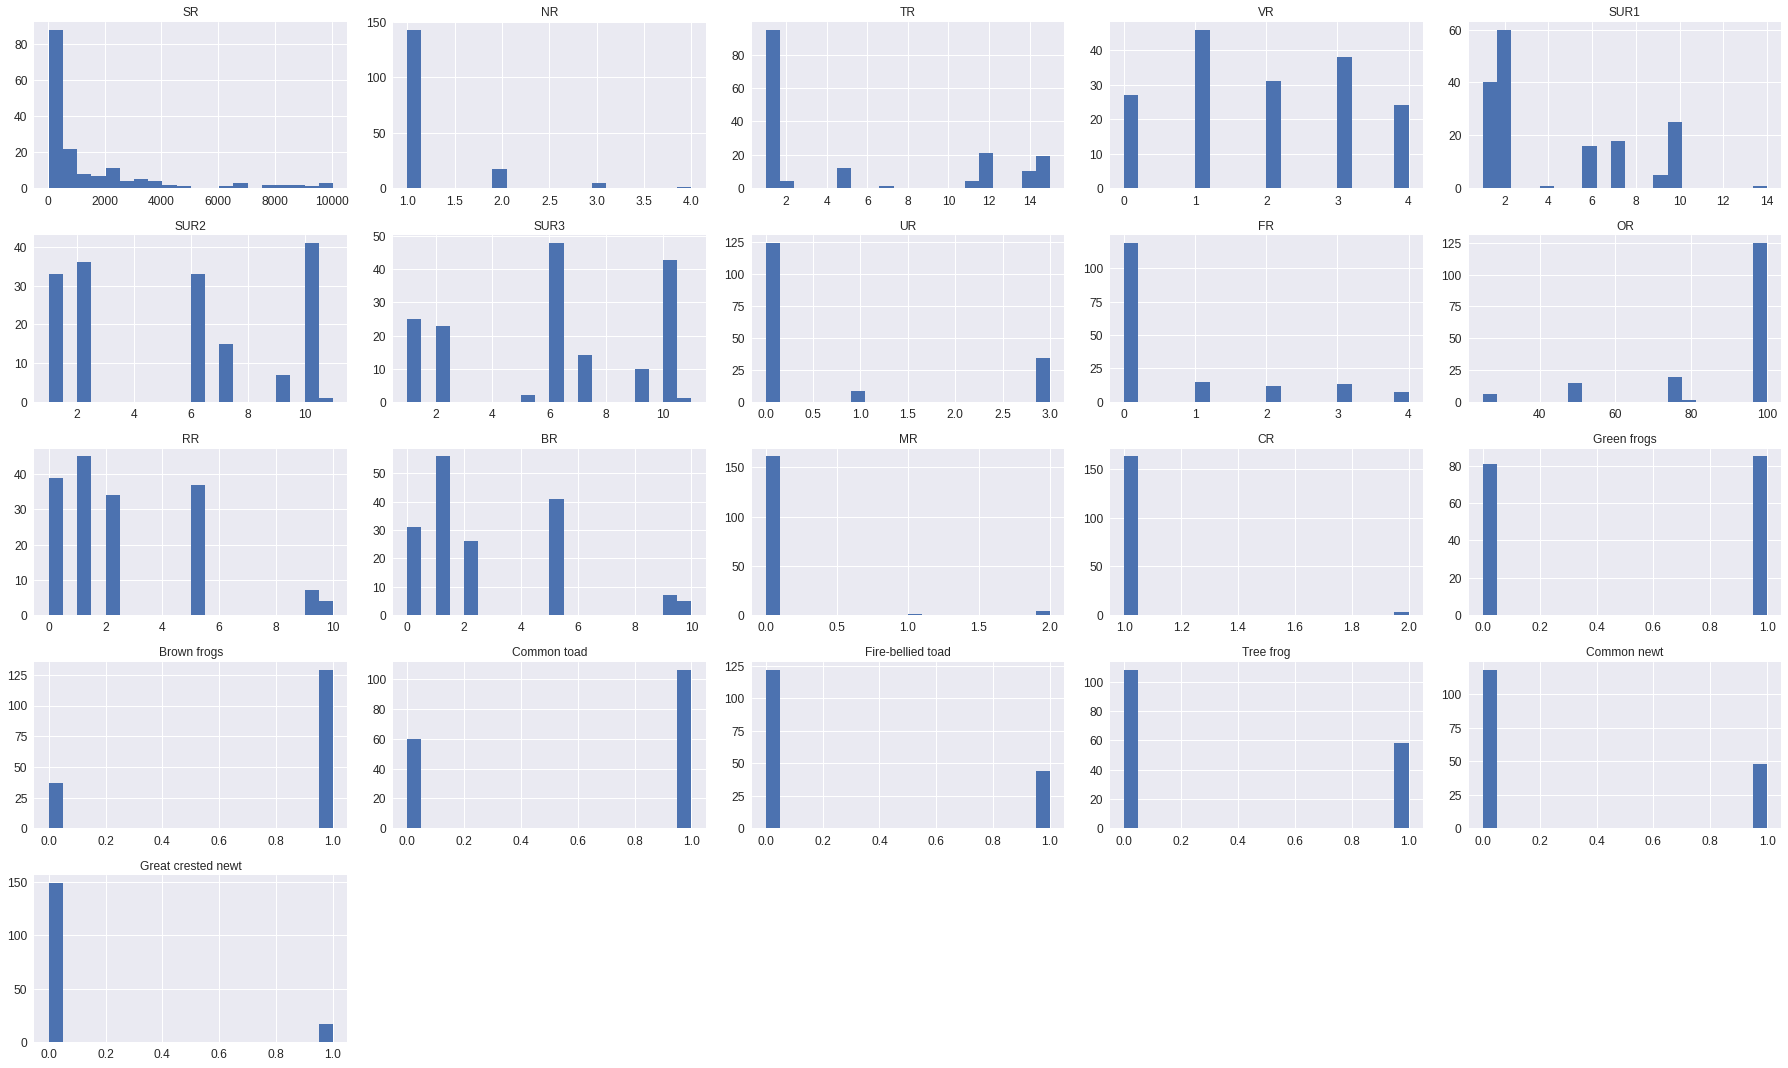

In [15]:
# Print histogram without outliers
amphibians_rem_out.hist(figsize=(25,15), bins=20)
plt.tight_layout()
plt.savefig('export/amphibians_rem_out_histogram.pdf', dpi=600)

### Imbalance dataset handling

In [16]:
# Separate independent and dependent features and targets
target_columns = ['Green frogs', 'Brown frogs', 'Common toad', 'Fire-bellied toad', 'Tree frog', 'Common newt', 'Great crested newt']

X = amphibians_rem_out.drop(columns=target_columns)  # All features
X_num = amphibians_rem_out[['SR', 'NR', 'OR']]  # Numerical features
X_cat = X.drop(columns=['SR', 'NR', 'OR'])  # Categorical features
y = amphibians_rem_out[target_columns]  # Targets

#### Categorical labels encoding

In [17]:
# Encode categorical labels
X_cat_enc = encode_labels(X_cat)

# Merge dataframes
X_enc = pd.concat([X_num, X_cat_enc], axis=1, ignore_index=False)


#### Multilabel oversampling

In [18]:
# Run multilabel oversampling
ratios = np.arange(0.1,2,0.1)
neighbors = np.arange(2,10, 1)

X_s, y_s = run_ml_sampling(X_enc, y, ratios, neighbors)

In [19]:
# Finalize datasets
X_s.columns = X.columns
y_s.columns = y.columns

In [20]:
# Round categorical values and merge datasets
X_s_round = X_s[X_cat.columns].round()
X_s_round = pd.concat([X_s[X_num.columns], X_s_round], axis=1, ignore_index=False)

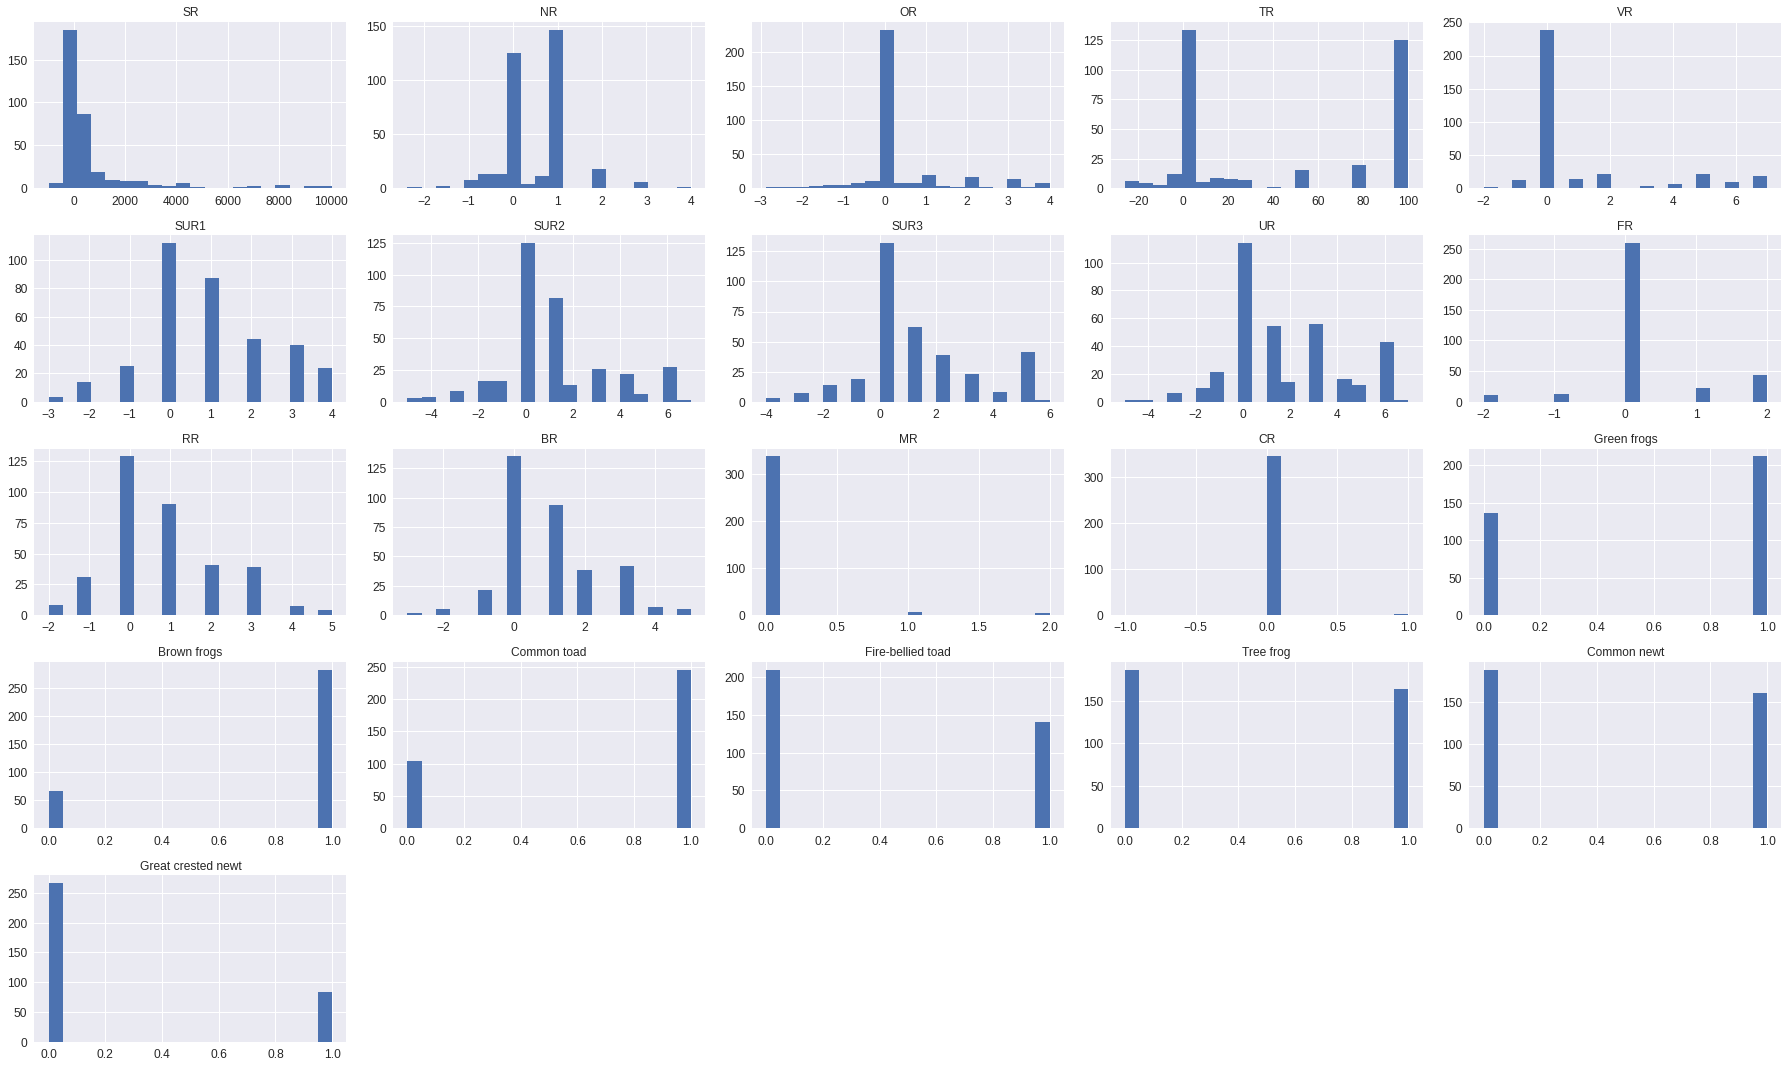

In [21]:
# Plot oversampled dataset
amphibians_oversample = pd.concat([X_s_round, y_s], axis=1, ignore_index=False)

amphibians_oversample.hist(figsize=(25,15), bins=20)
plt.tight_layout()
plt.savefig('export/amphibians_oversampled_histogram.pdf', dpi=600)

In [22]:
# Save the dataset
amphibians_oversample.to_pickle('data/amphibians_oversample.pickle')
# amphibians.to_pickle('data/amphibians_oversample.pickle')


### 4. Training of the multiple models and score comparison <a name="models-training"></a>

Training all models...


Training the Logistic model...



/mnt/Data/JK WORKS/Artificial_Intelligence/_Projects/20211107_Kendaxa_Tasks/04_Classification-Amphibians/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/mnt/Data/JK WORKS/Artificial_Intelligence/_Projects/20211107_Kendaxa_Tasks/04_Classification-Amphibians/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/mnt/Data/JK WORKS/Artificial_Intelligence/_Projects/20211107_Kendaxa_Tasks/04_Classification-Amphibians/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/mnt/Data/JK WORKS/Artificial_Int

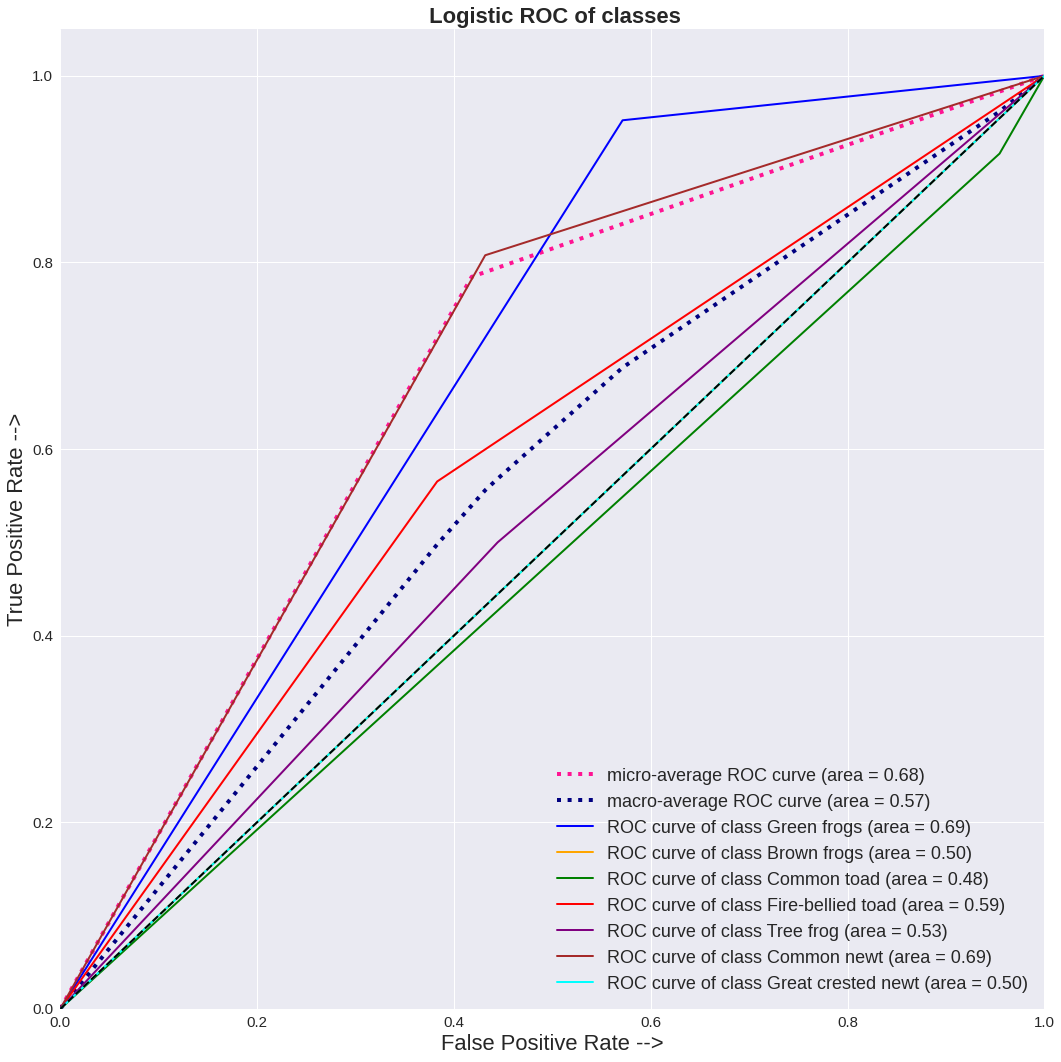


------ The best parameters of the Logistic model are: ------
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 MultiOutputClassifier(estimator=LogisticRegression(C=0.1437248071148783,
                                                                    penalty='l1',
                                                                    solver='liblinear')))])
--------------------------------------------------
The best cross-validation score: 0.6820502217839879
Accuracy: 0.02857142857142857
F1: 0.7134935304990757
ROC_AUC: 0.568338710171669
--------------------------------------------------

Logistic model training finished in: 0:00:05

Training the KNeighbor model...



/mnt/Data/JK WORKS/Artificial_Intelligence/_Projects/20211107_Kendaxa_Tasks/04_Classification-Amphibians/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/mnt/Data/JK WORKS/Artificial_Intelligence/_Projects/20211107_Kendaxa_Tasks/04_Classification-Amphibians/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/mnt/Data/JK WORKS/Artificial_Intelligence/_Projects/20211107_Kendaxa_Tasks/04_Classification-Amphibians/venv/lib/python3.9/site-packages/sklearn/metrics/_cla

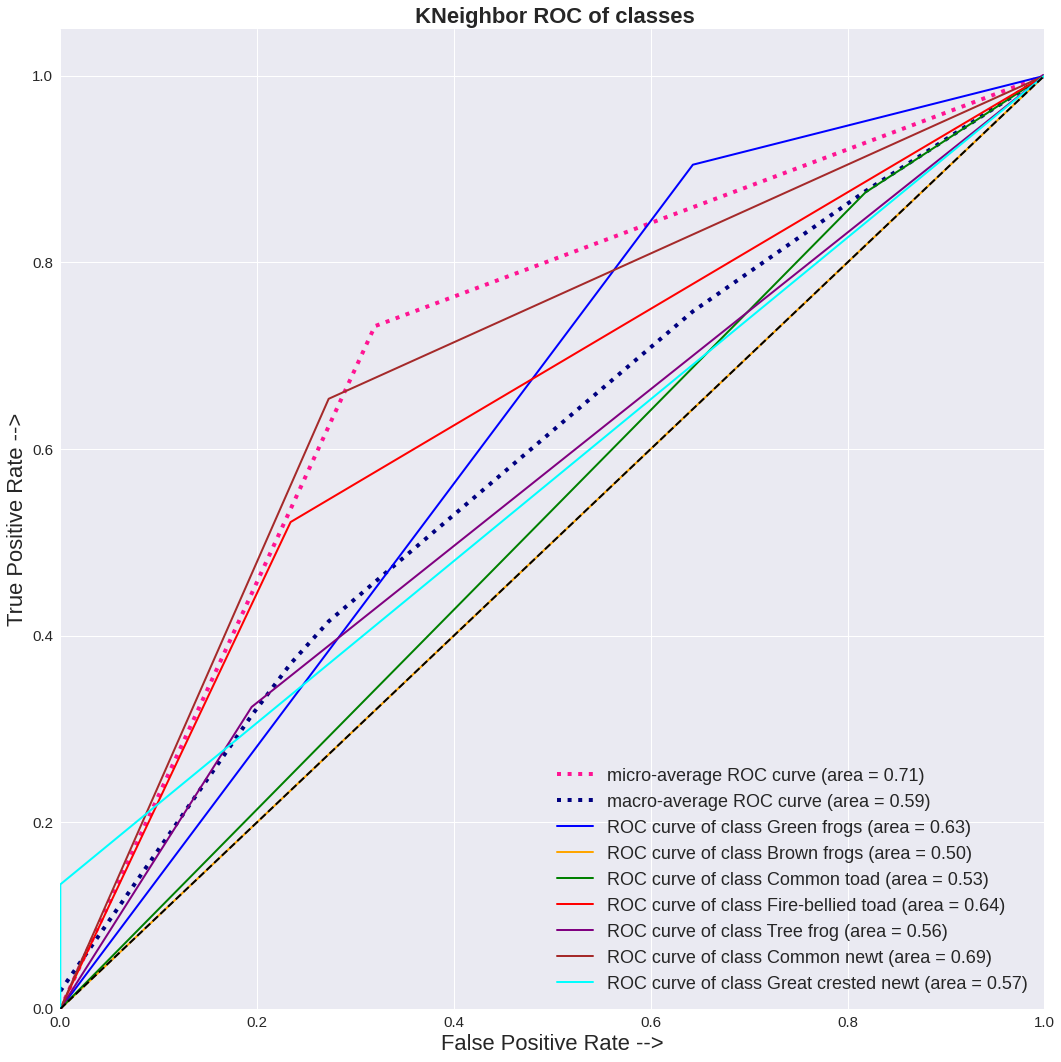


------ The best parameters of the KNeighbor model are: ------
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 MultiOutputClassifier(estimator=KNeighborsClassifier(algorithm='brute',
                                                                      leaf_size=14,
                                                                      metric='euclidean',
                                                                      n_neighbors=25,
                                                                      weights='distance')))])
--------------------------------------------------
The best cross-validation score: 0.6655507411059359
Accuracy: 0.08571428571428572
F1: 0.7142857142857143
ROC_AUC: 0.5892826216241938
--------------------------------------------------

KNeighbor model training finished in: 0:00:05

Training the Decision_Tree model...



/mnt/Data/JK WORKS/Artificial_Intelligence/_Projects/20211107_Kendaxa_Tasks/04_Classification-Amphibians/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/mnt/Data/JK WORKS/Artificial_Intelligence/_Projects/20211107_Kendaxa_Tasks/04_Classification-Amphibians/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/mnt/Data/JK WORKS/Artificial_Intelligence/_Projects/20211107_Kendaxa_Tasks/04_Classification-Amphibians/venv/lib/python3.9/site-packages/sklearn/metrics/_cla

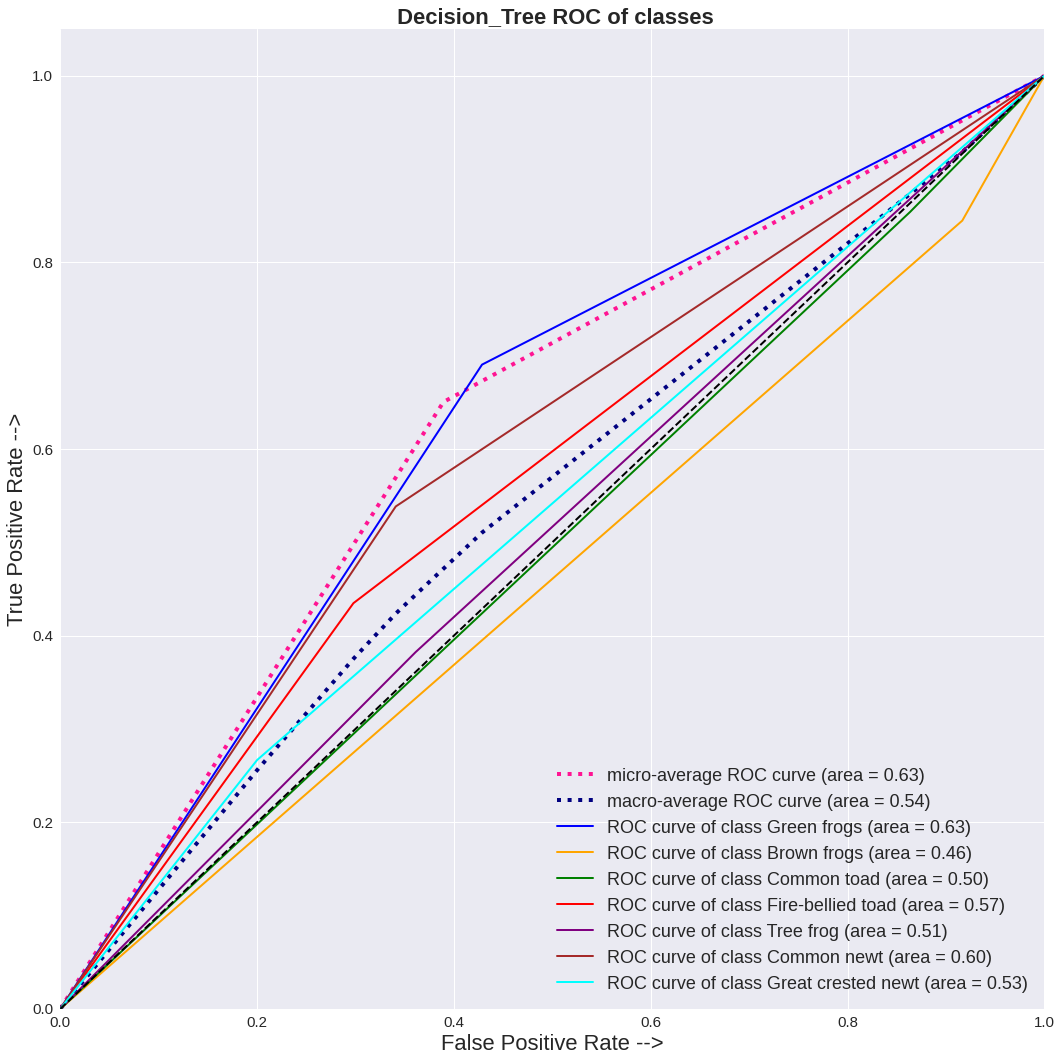


------ The best parameters of the Decision_Tree model are: ------
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 MultiOutputClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                        max_features='sqrt',
                                                                        min_samples_leaf=9,
                                                                        min_samples_split=5)))])
--------------------------------------------------
The best cross-validation score: 0.6551090057129019
Accuracy: 0.014285714285714285
F1: 0.6387225548902196
ROC_AUC: 0.5430690855021348
--------------------------------------------------

Decision_Tree model training finished in: 0:00:03

Training the Random_Forest model...



/mnt/Data/JK WORKS/Artificial_Intelligence/_Projects/20211107_Kendaxa_Tasks/04_Classification-Amphibians/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/mnt/Data/JK WORKS/Artificial_Intelligence/_Projects/20211107_Kendaxa_Tasks/04_Classification-Amphibians/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/mnt/Data/JK WORKS/Artificial_Intelligence/_Projects/20211107_Kendaxa_Tasks/04_Classification-Amphibians/venv/lib/python3.9/site-packages/sklearn/metrics/_cla

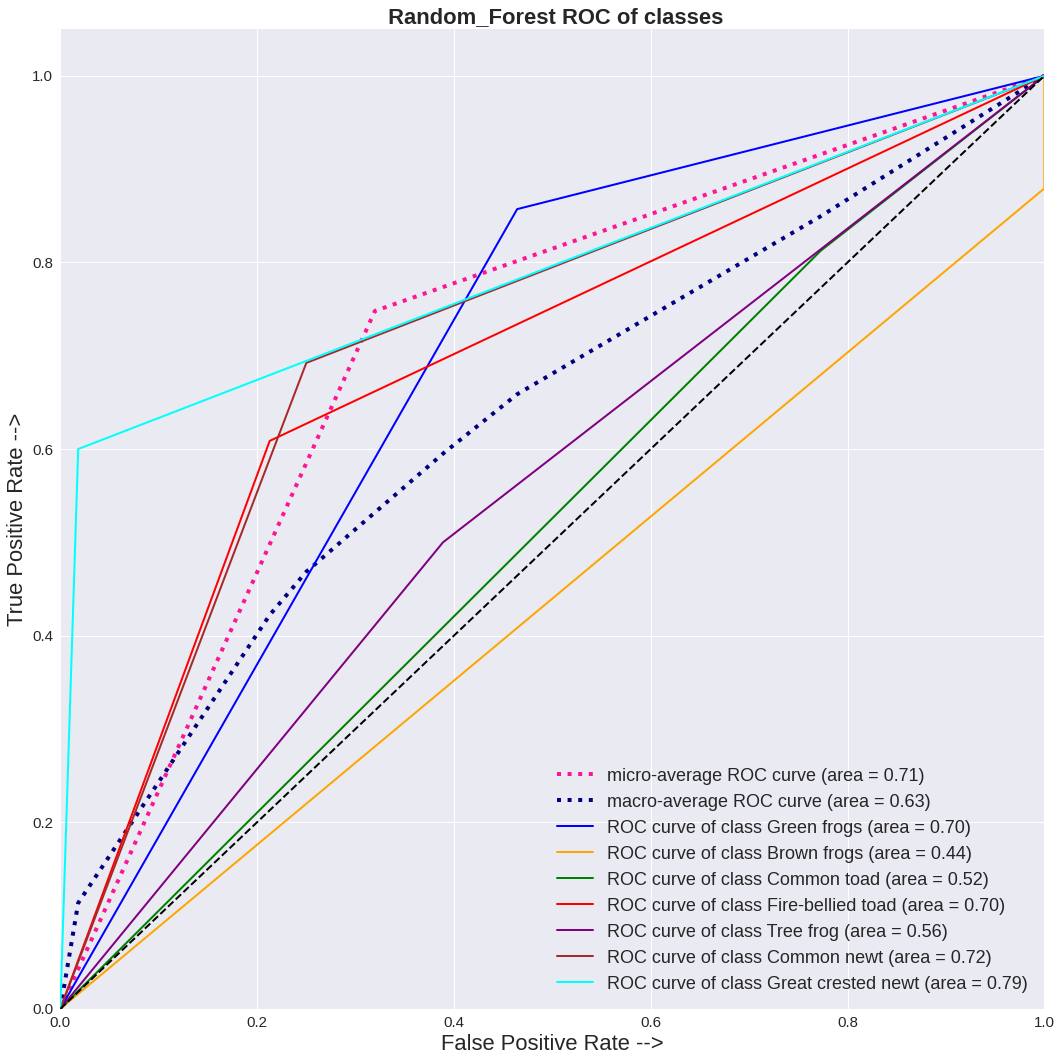


------ The best parameters of the Random_Forest model are: ------
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=False,
                                                                        criterion='entropy',
                                                                        max_depth=50,
                                                                        max_features='sqrt',
                                                                        min_samples_leaf=2,
                                                                        n_estimators=850)))])
--------------------------------------------------
The best cross-validation score: 0.6983679087867399
Accuracy: 0.1
F1: 0.7244094488188976
ROC_AUC: 0.6316504924943962
--------------------------------------------------

Random_Forest model training finished in: 0:10:01


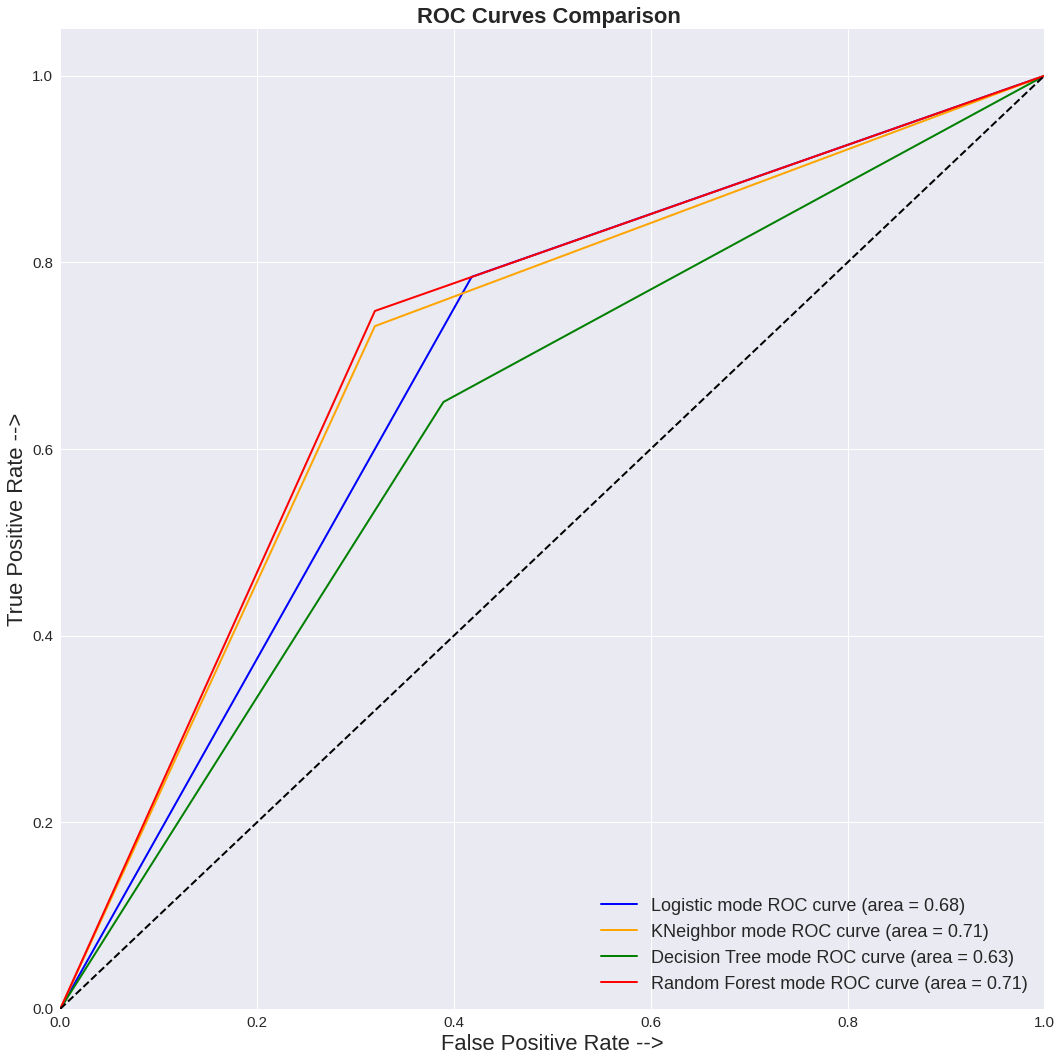


All models trained in: 0:10:17


<Figure size 576x396 with 0 Axes>

In [23]:
# Load and extract data from raw CSVs into dataframes for S&P500 and relevant events
%run lib/models_training.py


#### Dataset with predicted values export

In [24]:
# Selecting the features
amphibians_eval = X_test[X_test.columns]

In [25]:
# Concantenate dataframes
amphibians_eval = concat_df(amphibians_eval, y_test, '')  # Concating the ground truth volume
amphibians_eval = concat_df(amphibians_eval, l_y_pred, '-Logistic pred')  # Concating the Random Forest volume
amphibians_eval = concat_df(amphibians_eval, kn_y_pred, '-KNeighbor pred')  # Concating the Ada Boost volume
amphibians_eval = concat_df(amphibians_eval, dt_y_pred, '-Decision Tree pred')  # Concating the Gradient Boost volume
amphibians_eval = concat_df(amphibians_eval, rf_y_pred, '-Random Forest pred')  # Concating the XGBoost volume

In [26]:
# Sorting according to index
amphibians_eval.sort_index(ascending=True, inplace=True)
amphibians_eval.reset_index(drop=True, inplace=True)

In [27]:
# Export to csv
amphibians_eval.to_csv('export/amphibians_eval_data.csv', header=True)

### 5. Results Discussion and Conclusion <a name="conclusion"></a>